In [47]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
# Settings
filepath = "optimization/results/beam_search_old_parents_included_1e5_run1.hdf5"
# Note: I kept your list, but check if [1225,25655] is a typo for [1225,25]
code_names = ["[625,25]", "[1225,65]", "[1600,64]", "[2025,81]"]
BEAM_WIDTH = 3             

# Define distinct colors for the children of each parent
PARENT_COLORS = ['tab:orange', 'tab:purple', 'tab:pink']

def plot_beam_search_subplots(filepath, code_names):
    # Initialize the 2x2 figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Increased size for visibility
    axes = axes.flatten() # Flatten 2D array to 1D for easy iteration

    with h5py.File(filepath, "r") as f:
        for idx, code_name in enumerate(code_names):
            # Safety check: if we have more codes than plots
            if idx >= len(axes):
                print(f"Warning: More codes than subplots. Skipping {code_name}")
                continue

            ax = axes[idx] # Get the specific axis for this code

            if code_name not in f:
                print(f"Code {code_name} not found. Available: {list(f.keys())}")
                ax.text(0.5, 0.5, f"{code_name} Not Found", 
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax.transAxes)
                continue
            
            grp = f[code_name]
        
            # --- DATA LOADING ---
            lers = grp["logical_error_rates"][:]
            stds = grp["logical_error_rates_std"][:]
            summaries = grp["step_summaries"][:] 
            survivor_indices_table = grp["beam_survivors"][:]
            best_state_edge_list = grp["best_state"][:]

            evaluated_lers = np.where(lers > 0, lers, np.inf)
            min_idx = np.argmin(evaluated_lers)

            if len(evaluated_lers) > 0:
                min_ler = np.min(evaluated_lers)
                print(
                    f"[{code_name}] Best found logical error rate: {evaluated_lers[min_idx]:.5f} ± {stds[min_idx]} in index {min_idx}")
            else:
                print(f"[{code_name}] No evaluated error rates found (all zeros).")

            # best_state = from_edgelist(best_state_edge_list)
            print(f"Best State: {best_state_edge_list}")
            print(
                f"Total runtime for [{code_name}]: {grp.attrs['total_runtime'] // 3600}h {grp.attrs['total_runtime'] % 3600 // 60}m {grp.attrs['total_runtime'] % 60}s")

            if "parent_idx" in grp:
                parent_indices = grp["parent_idx"][:]
            else:
                print(f"Warning: 'parent_idx' not found for {code_name}. Defaulting to 0.")
                parent_indices = np.zeros(len(lers), dtype=int)

            steps_data = []
            
            # --- DATA ALIGNMENT ---
            num_steps = min(len(summaries), len(survivor_indices_table))
            
            # Start loop at 1 to skip initialization row
            for i in range(num_steps):
                row = summaries[i]
                start_idx = int(row[0])
                count = int(row[1])
                
                # Slice data for this step (The Cloud)
                cloud_lers = lers[start_idx : start_idx + count]
                cloud_stds = stds[start_idx : start_idx + count]
                cloud_parents = parent_indices[start_idx : start_idx + count]

                # Get survivors for this SAME step index
                step_survivor_indices = survivor_indices_table[i]
                
                step_survivors = []
                for global_idx in step_survivor_indices:
                    if global_idx != -1 and global_idx < len(lers):
                        step_survivors.append((lers[global_idx], stds[global_idx]))
                
                best_of_step = min(step_survivors, key=lambda x: x[0]) if step_survivors else None
                
                steps_data.append({
                    "step_num": i,
                    "cloud_lers": cloud_lers,
                    "cloud_stds": cloud_stds,
                    "cloud_parents": cloud_parents,
                    "survivors": step_survivors,
                    "best_of_step": best_of_step
                })

            # --- PLOTTING ON SUBPLOT (ax) ---
            
            # 1. Plot the "Search Cloud" (COLORED BY PARENT)
            for data in steps_data:
                step_x = data["step_num"]
                
                if len(data["cloud_lers"]) > 0:
                    x_vals = np.ones(len(data["cloud_lers"])) * step_x
                    jitter = np.random.normal(0, 0.06, size=len(x_vals))
                    
                    for p_id in range(BEAM_WIDTH):
                        mask = (data["cloud_parents"] == p_id)
                        if np.any(mask):
                            ax.errorbar(x_vals[mask] + jitter[mask], 
                                        data["cloud_lers"][mask], 
                                        yerr=data["cloud_stds"][mask], 
                                        fmt='o', 
                                        color=PARENT_COLORS[p_id % len(PARENT_COLORS)], 
                                        alpha=0.6, 
                                        ms=2, 
                                        zorder=0,
                                        label=f'Child of P{p_id}' if step_x==1 else "")

            # 2. Plot Survivors (Blue Dots)
            for data in steps_data:
                step_x = data["step_num"]
                for survivor in data["survivors"]:
                    ax.errorbar(step_x, survivor[0], yerr=survivor[1],
                                fmt='o', color='tab:blue', alpha=1.0, ms=4, zorder=1, 
                                label='Parents' if step_x==1 else "")

            # 3. Plot Best Path (Green Line)
            best_x = []
            best_y = []
            best_yerr = []

            for data in steps_data:
                if data["best_of_step"]:
                    best_x.append(data["step_num"])
                    best_y.append(data["best_of_step"][0])
                    best_yerr.append(data["best_of_step"][1])
            
            if best_x:
                ax.plot(best_x, best_y, color='tab:blue', linestyle='-', linewidth=1.5, zorder=2)
                # Mark overall best
                min_y = min(best_y)
                for k in range(len(best_x)):
                    if best_y[k] == min_y:
                        ax.plot(best_x[k], best_y[k], marker='*', color='green', markersize=12, zorder=4, label='Overall Best')
                        break # Only label once
            
            # --- SUBPLOT STYLING ---
            ax.set_yscale('log')
            ax.set_xlabel('Step $l$')
            ax.set_ylabel('Logical Error Rate $p_L$')
            ax.set_title(f'Code: [{code_name}]')
            ax.grid(True, which="both", ls="-", alpha=0.2)
            
            # Optional: Only show legend on the first plot to save space, 
            # or on all of them if they differ. Here I put it on all but small.
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small')

    plt.suptitle(f"Best Neighbor Search + Mutation + Old Parents Included (N Parents={BEAM_WIDTH}, MC budget=1e5)", fontsize=16)
    plt.tight_layout()
    plt.show()

Best x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], Best y: [0.01234, 0.00712, 0.00457, 0.00421, 0.00373, 0.00401, 0.00377, 0.00375, 0.00383, 0.00362], Best yerr: [0.0003491109605621511, 0.00026588298730386903, 0.00021328761313320363, 0.00020475150361299503, 0.00019277251518934463, 0.00019984893894135127, 0.0001937995009861115, 0.00019328670051890783, 0.00019532970213699034, 0.00018991923729092566]


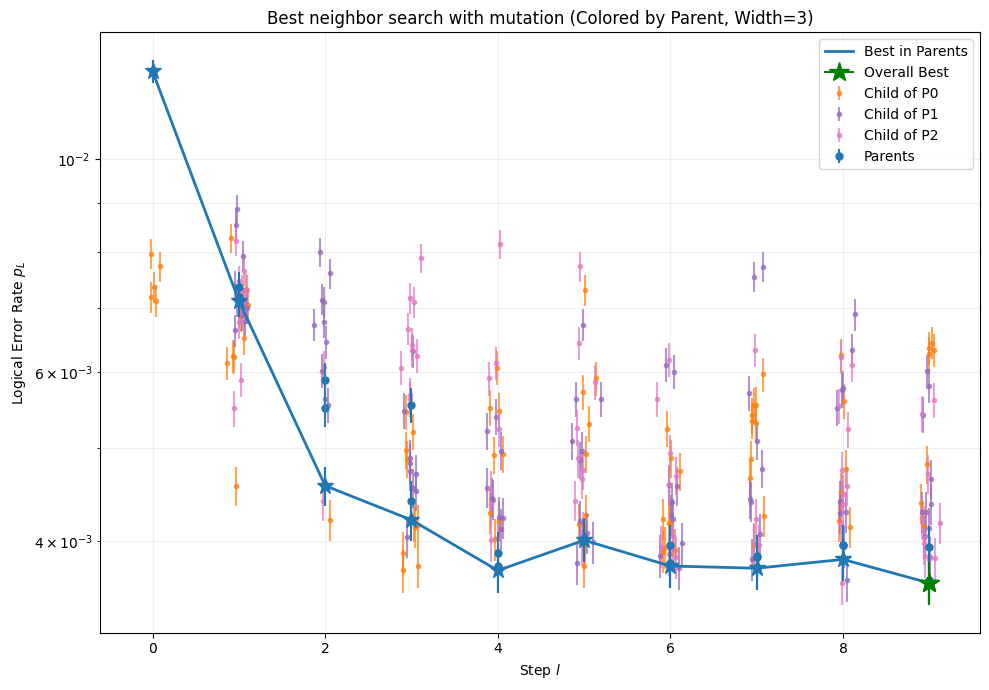

In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Settings
filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
BEAM_WIDTH = 3             

# Define distinct colors for the children of each parent
PARENT_COLORS = ['tab:orange', 'tab:purple', 'tab:pink']

def plot_beam_search_colored(filepath, code_name):
    with h5py.File(filepath, "r") as f:
        if code_name not in f:
            print(f"Code {code_name} not found. Available: {list(f.keys())}")
            return
        grp = f[code_name]
        
        # Load datasets
        lers = grp["logical_error_rates"][:]
        stds = grp["logical_error_rates_std"][:]
        summaries = grp["step_summaries"][:] 
        survivor_indices_table = grp["beam_survivors"][:] 
        
        # Robustly handle missing parent_idx
        if "parent_idx" in grp:
            parent_indices = grp["parent_idx"][:]
        else:
            print("Warning: 'parent_idx' not found. Defaulting to 0.")
            parent_indices = np.zeros(len(lers), dtype=int)

        steps_data = []
        
        # --- ALIGNMENT FIX ---
        # The simulation initializes both datasets with a "dummy/seed" row at index 0.
        # summaries[0] is [0,0,0,-1] (empty). survivors[0] is the start state.
        # The actual search steps start at index 1.
        
        num_steps = min(len(summaries), len(survivor_indices_table))
        
        # Start loop at 1 to skip the initialization row
        for i in range(num_steps):
            row = summaries[i]
            start_idx = int(row[0])
            count = int(row[1])
            
            # Slice data for this step (The Cloud)
            cloud_lers = lers[start_idx : start_idx + count]
            cloud_stds = stds[start_idx : start_idx + count]
            cloud_parents = parent_indices[start_idx : start_idx + count]

            # Get survivors for this SAME step index
            step_survivor_indices = survivor_indices_table[i]
            
            step_survivors = []
            for global_idx in step_survivor_indices:
                # Filter out -1 paddings and validity check
                if global_idx != -1 and global_idx < len(lers):
                    step_survivors.append((lers[global_idx], stds[global_idx]))
            
            best_of_step = min(step_survivors, key=lambda x: x[0]) if step_survivors else None
            
            steps_data.append({
                "step_num": i,
                "cloud_lers": cloud_lers,
                "cloud_stds": cloud_stds,
                "cloud_parents": cloud_parents,
                "survivors": step_survivors,
                "best_of_step": best_of_step
            })

    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 1. Plot the "Search Cloud" (COLORED BY PARENT)
    for data in steps_data:
        step_x = data["step_num"]
        
        if len(data["cloud_lers"]) > 0:
            x_vals = np.ones(len(data["cloud_lers"])) * step_x
            # Add jitter
            jitter = np.random.normal(0, 0.06, size=len(x_vals))
            
            for p_id in range(BEAM_WIDTH):
                mask = (data["cloud_parents"] == p_id)
                if np.any(mask):
                    ax.errorbar(x_vals[mask] + jitter[mask], 
                                data["cloud_lers"][mask], 
                                yerr=data["cloud_stds"][mask], 
                                fmt='o', 
                                color=PARENT_COLORS[p_id % len(PARENT_COLORS)], 
                                alpha=0.7, # Slightly transparent to see density
                                ms=3, 
                                zorder=0,
                                label=f'Child of P{p_id}' if step_x==1 else "")

    # 2. Plot Survivors (Blue Dots)
    for data in steps_data:
        step_x = data["step_num"]
        for survivor in data["survivors"]:
            ax.errorbar(step_x, survivor[0], yerr=survivor[1],
                        fmt='o', color='tab:blue', alpha=1.0, ms=5, zorder=1, label='Parents' if step_x==1 else "")

    # 3. Plot Best Path (Green Line)
    best_x = []
    best_y = []
    best_yerr = []

    for data in steps_data:
        if data["best_of_step"]:
            best_x.append(data["step_num"])
            best_y.append(data["best_of_step"][0])
            best_yerr.append(data["best_of_step"][1])
    
    if best_x:
        ax.plot(best_x, best_y, color='tab:blue', linestyle='-', linewidth=2, zorder=2, label='Best in Parents')
        ax.errorbar(best_x, best_y, yerr=best_yerr, fmt='*', color='tab:blue', ms=12, zorder=3)
        for i in range(len(best_x)):
            if best_y[i] == min(best_y):
                ax.plot(best_x[i], best_y[i], marker='*', color='green', markersize=15, zorder=4, label='Overall Best')
                ax.errorbar(best_x[i], best_y[i], yerr=best_yerr[i], fmt='*', color='green', ms=15, zorder=4)
    print(f"Best x: {best_x}, Best y: {best_y}, Best yerr: {best_yerr}")
    # Styling
    ax.set_yscale('log')
    ax.set_xlabel('Step $l$')
    ax.set_ylabel('Logical Error Rate $p_L$')
    ax.set_title(f'Best neighbor search with mutation (Colored by Parent, Width={BEAM_WIDTH})')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Legend (Deduplicated)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_beam_search_colored(filepath, code_name)

In [26]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
        
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

Best state edge list: [[ 0 15  0 24  0 30  0 32  1 15  1 21  1 22  1 25  2 15  2 26  2 31  2 32
   2 34  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 20  5 23
   5 27  6 17  6 20  6 27  6 33  7 17  7 22  7 28  7 31  8 17  8 23  8 29
   8 30  9 18  9 18  9 28  9 32 10 18 10 23 10 26 10 33 11 21 11 24 11 29
  11 34 12 19 12 21 12 27 12 34 13 19 13 24 13 28 13 33 14 19 14 25 14 29]]
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 13.78s with 369 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00369 ± 0.0001917 (stderr)


In [ ]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/best_neighbor_search_early_stop.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
    
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

Best state edge list: [[ 0 20  0 20  0 24  0 30  1 15  1 21  1 25  1 31  2 15  2 22  2 26  2 28
   2 34  3 15  3 16  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 28
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 27  7 31  8 17  8 21  8 23
   8 30  9 21  9 28  9 32  9 33 10 18 10 18 10 23 10 26 11 18 11 24 11 29
  11 34 12 19 12 27 12 29 12 34 13 19 13 24 13 32 13 33 14 19 14 25 14 29]]
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 16.67s with 345 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00345 ± 0.0001854 (stderr)


In [27]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/best_neighbor_search_early_stop.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
    
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

for i in range(5):
    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

Best state edge list: [[ 0 20  0 20  0 24  0 30  1 15  1 21  1 25  1 31  2 15  2 22  2 26  2 28
   2 34  3 15  3 16  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 28
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 27  7 31  8 17  8 21  8 23
   8 30  9 21  9 28  9 32  9 33 10 18 10 18 10 23 10 26 11 18 11 24 11 29
  11 34 12 19 12 27 12 29 12 34 13 19 13 24 13 32 13 33 14 19 14 25 14 29]]
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 17.55s with 339 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00339 ± 0.0001838 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 16.86s with 364 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00364 ± 0.0001904 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 16.25s with 337 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00337 ± 0.0001833 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [

In [25]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
        
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

for i in range(5):
    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 14.02s with 412 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00412 ± 0.0002026 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 13.71s with 433 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00433 ± 0.0002076 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 12.61s with 418 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00418 ± 0.000

In [28]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
        
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

Best state edge list: [[ 0 15  0 24  0 30  0 32  1 15  1 21  1 22  1 25  2 15  2 26  2 31  2 32
   2 34  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 20  5 23
   5 27  6 17  6 20  6 27  6 33  7 17  7 22  7 28  7 31  8 17  8 23  8 29
   8 30  9 18  9 18  9 28  9 32 10 18 10 23 10 26 10 33 11 21 11 24 11 29
  11 34 12 19 12 21 12 27 12 34 13 19 13 24 13 28 13 33 14 19 14 25 14 29]]


# Beam Search + Multi Parents + Old Parents Run1

[[625,25]] Best found logical error rate: 0.00386 ± 0.00019609025604013357 in index 976
Best State: [[ 0 15  0 20  0 24  0 30  1 15  1 21  1 25  1 31  2 15  2 22  2 26  2 32
   2 34  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 27
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 26  7 31  8 17  8 23  8 23
   8 30  9 18  9 19  9 28  9 32 10 28 10 29 10 33 10 34 11 18 11 18 11 24
  11 29 12 19 12 21 12 27 12 34 13 21 13 24 13 28 13 33 14 19 14 25 14 29]]
Total runtime for [[625,25]]: 4.0h 49.0m 24.39677381515503s
[[1225,65]] Best found logical error rate: 0.00178 ± 0.00013329851343858582 in index 971
Best State: [[ 0 21  0 28  0 35  0 42  0 48  1 21  1 29  1 36  1 41  2 21  2 30  2 37
   2 43  3 22  3 38  3 39  3 43  3 47  4 22  4 31  4 36  4 42  5 32  5 34
   5 37  5 44  6 23  6 28  6 34  6 44  7 23  7 33  7 36  7 43  8 23  8 38
   8 39  8 46  9 24  9 29  9 45  9 45 10 24 10 31 10 35 10 46 11 24 11 33
  11 40 11 44 12 25 12 29 12 37 12 40 13 25 13 32 13 35 13 45 14 25 14 

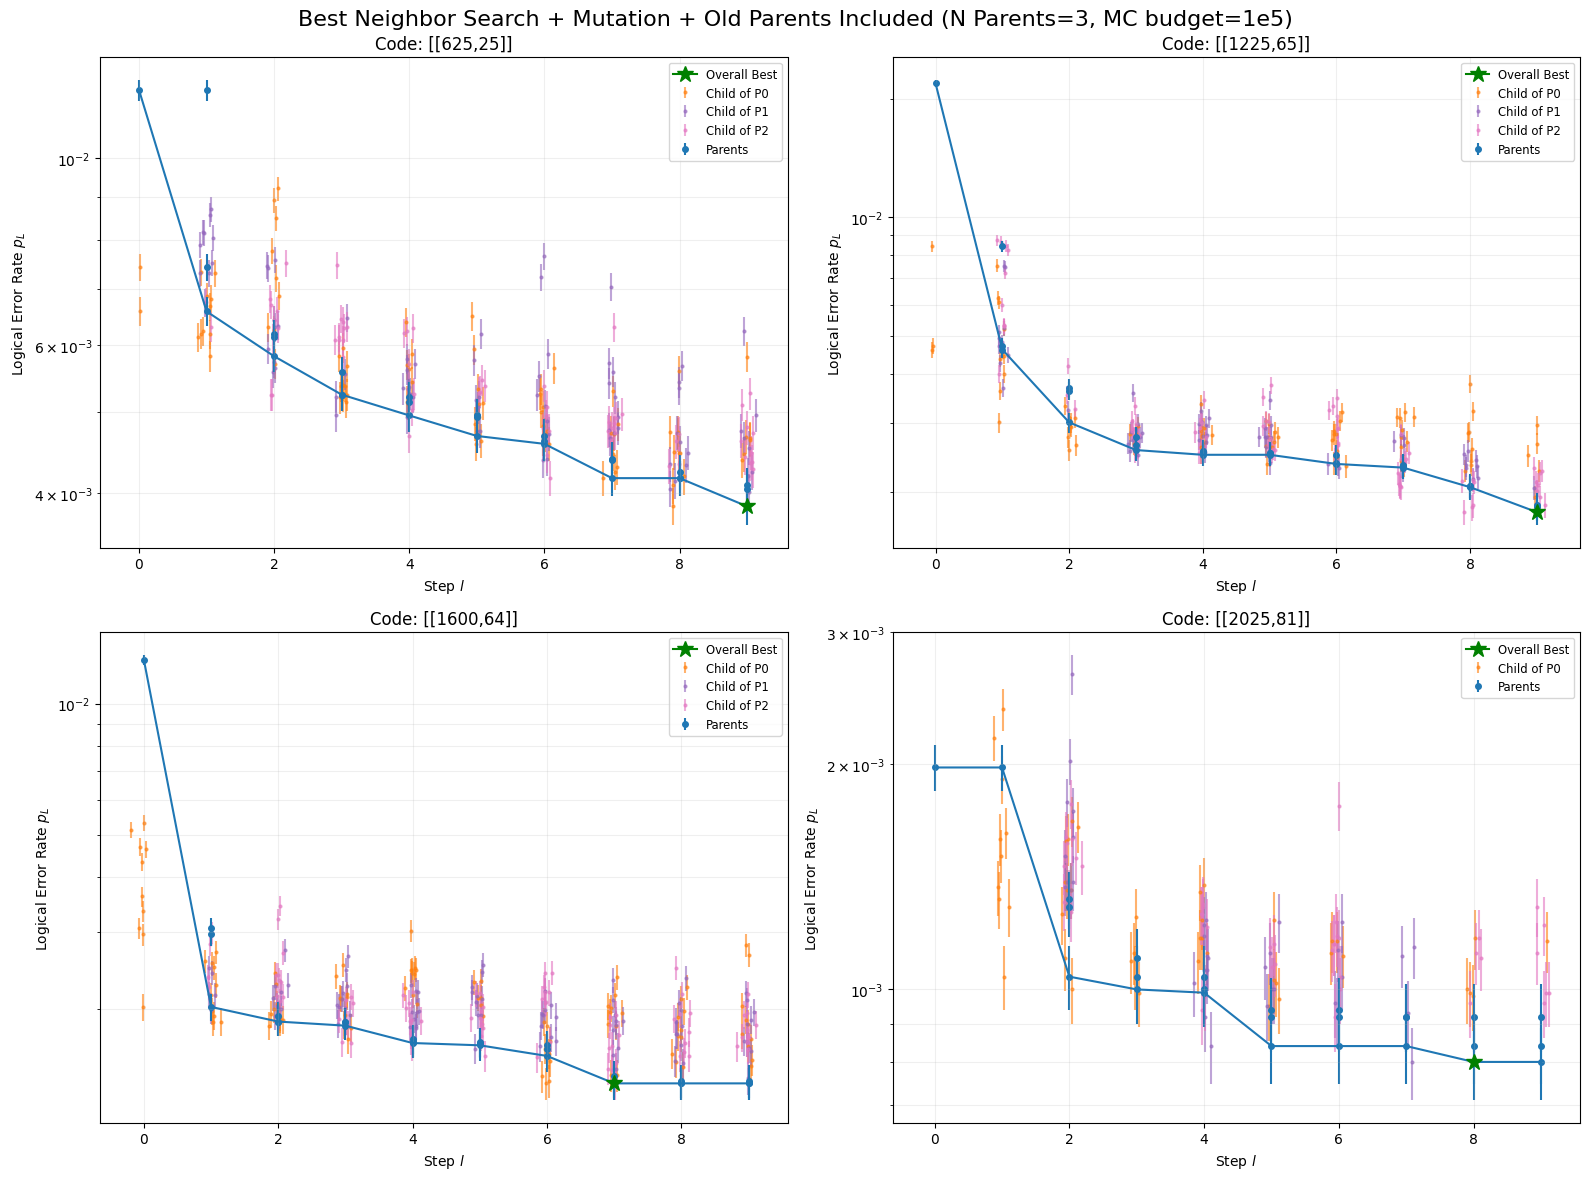

In [ ]:
# Settings
filepath = "optimization/results/beam_search_old_parents_included_1e5_run1.hdf5"
# Note: I kept your list, but check if [1225,25655] is a typo for [1225,25]
code_names = ["[625,25]", "[1225,65]", "[1600,64]", "[2025,81]"]
BEAM_WIDTH = 3    

if __name__ == "__main__":
    plot_beam_search_subplots(filepath, code_names)

# Beam Search + Multi Parents + Old Parents Run2

[[625,25]] Best found logical error rate: 0.00422 ± 0.00020499350288085284 in index 1113
Best State: [[ 0 15  0 20  0 24  0 29  1 15  1 21  1 25  1 31  2 15  2 22  2 26  2 28
   2 32  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 27
   5 32  6 17  6 17  6 27  6 33  7 17  7 24  7 28  7 31  8 18  8 23  8 29
   8 30  9 20  9 21  9 32  9 34 10 18 10 23 10 26 10 33 11 18 11 24 11 29
  11 34 12 19 12 21 12 27 12 34 13 19 13 22 13 28 13 33 14 19 14 25 14 30]]
Total runtime for [[625,25]]: 5.0h 12.0m 52.14839768409729s


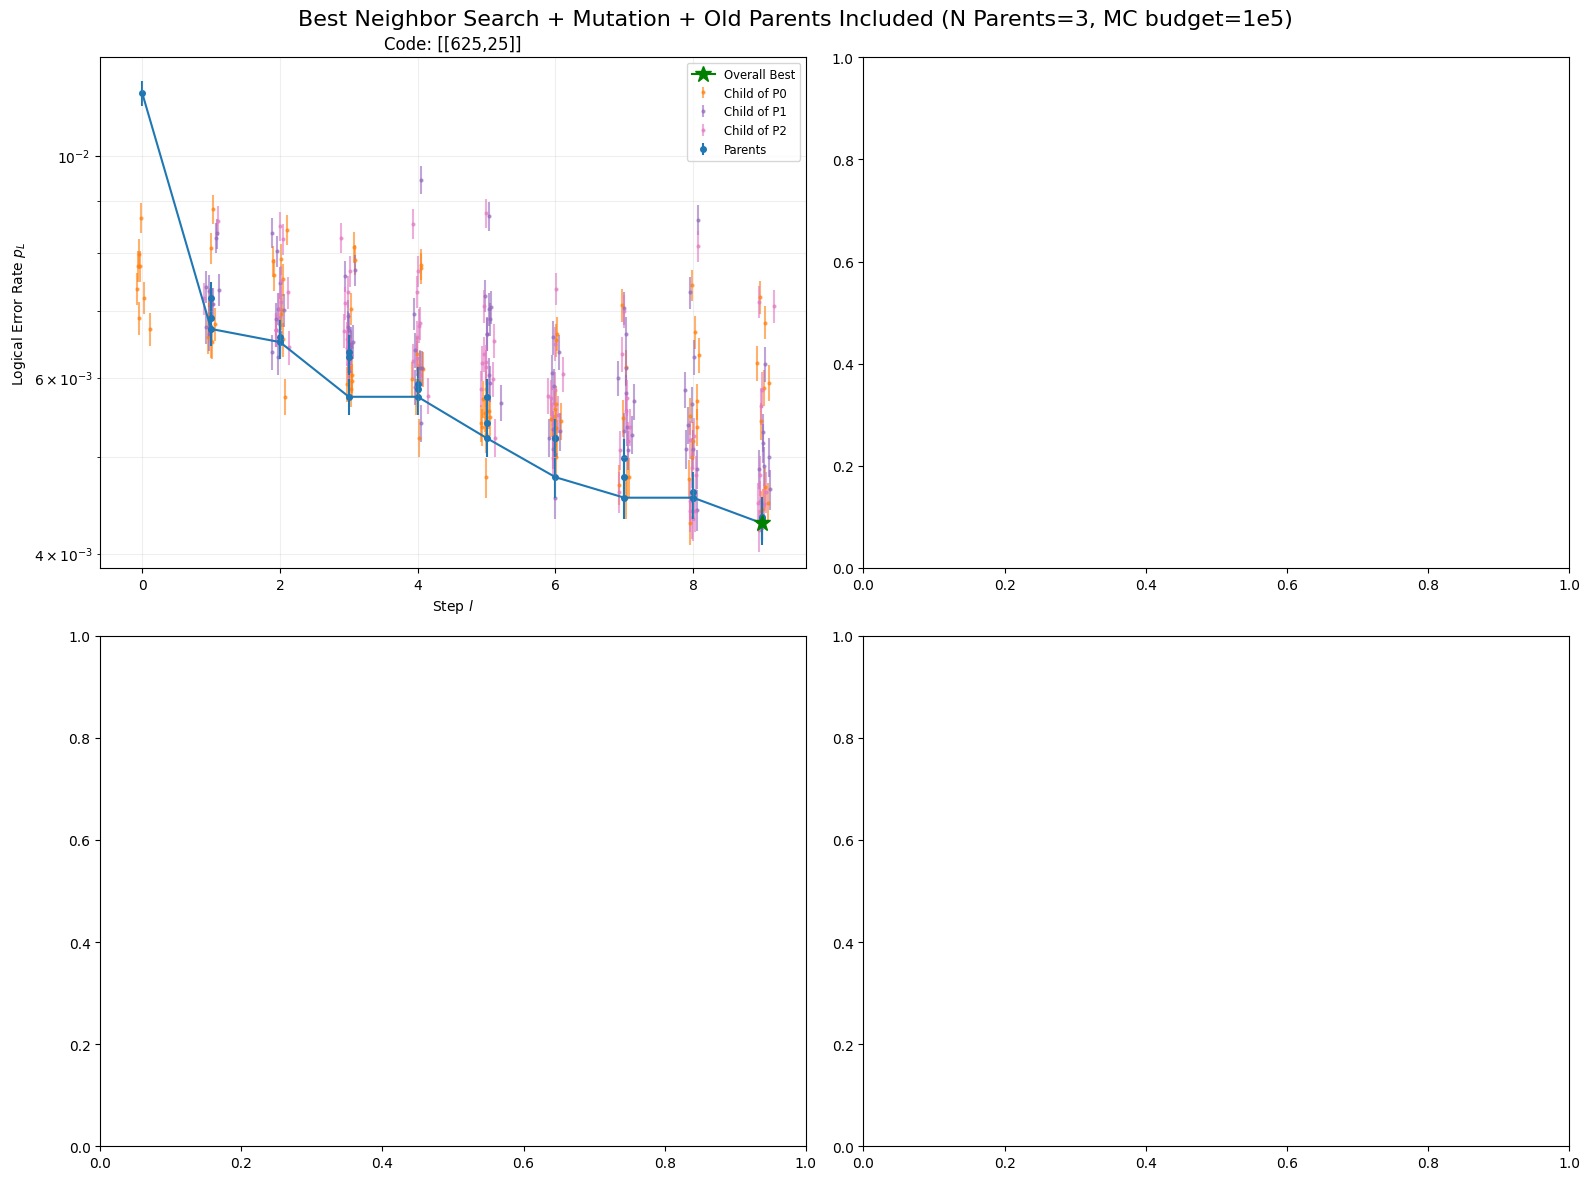

In [45]:
# Settings
filepath = "optimization/results/beam_search_old_parents_included_1e5_run2.hdf5"
code_names = ["[625,25]"]
BEAM_WIDTH = 3    

if __name__ == "__main__":
    plot_beam_search_subplots(filepath, code_names)

[[625,25]] Best found logical error rate: 0.00420 ± 0.00020450921309364626 in index 1093
Best State: [[ 0 15  0 20  0 24  0 30  1 16  1 19  1 21  1 26  2 15  2 22  2 25  2 32
   2 34  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 17  5 27  5 31
   5 32  6 20  6 23  6 27  6 33  7 17  7 22  7 28  7 31  8 17  8 23  8 29
   8 30  9 18  9 21  9 28  9 32 10 18 10 23 10 26 10 33 11 18 11 28 11 29
  11 34 12 15 12 21 12 27 12 34 13 19 13 24 13 24 13 33 14 19 14 25 14 29]]
Total runtime for [[625,25]]: 4.0h 35.0m 42.24490976333618s


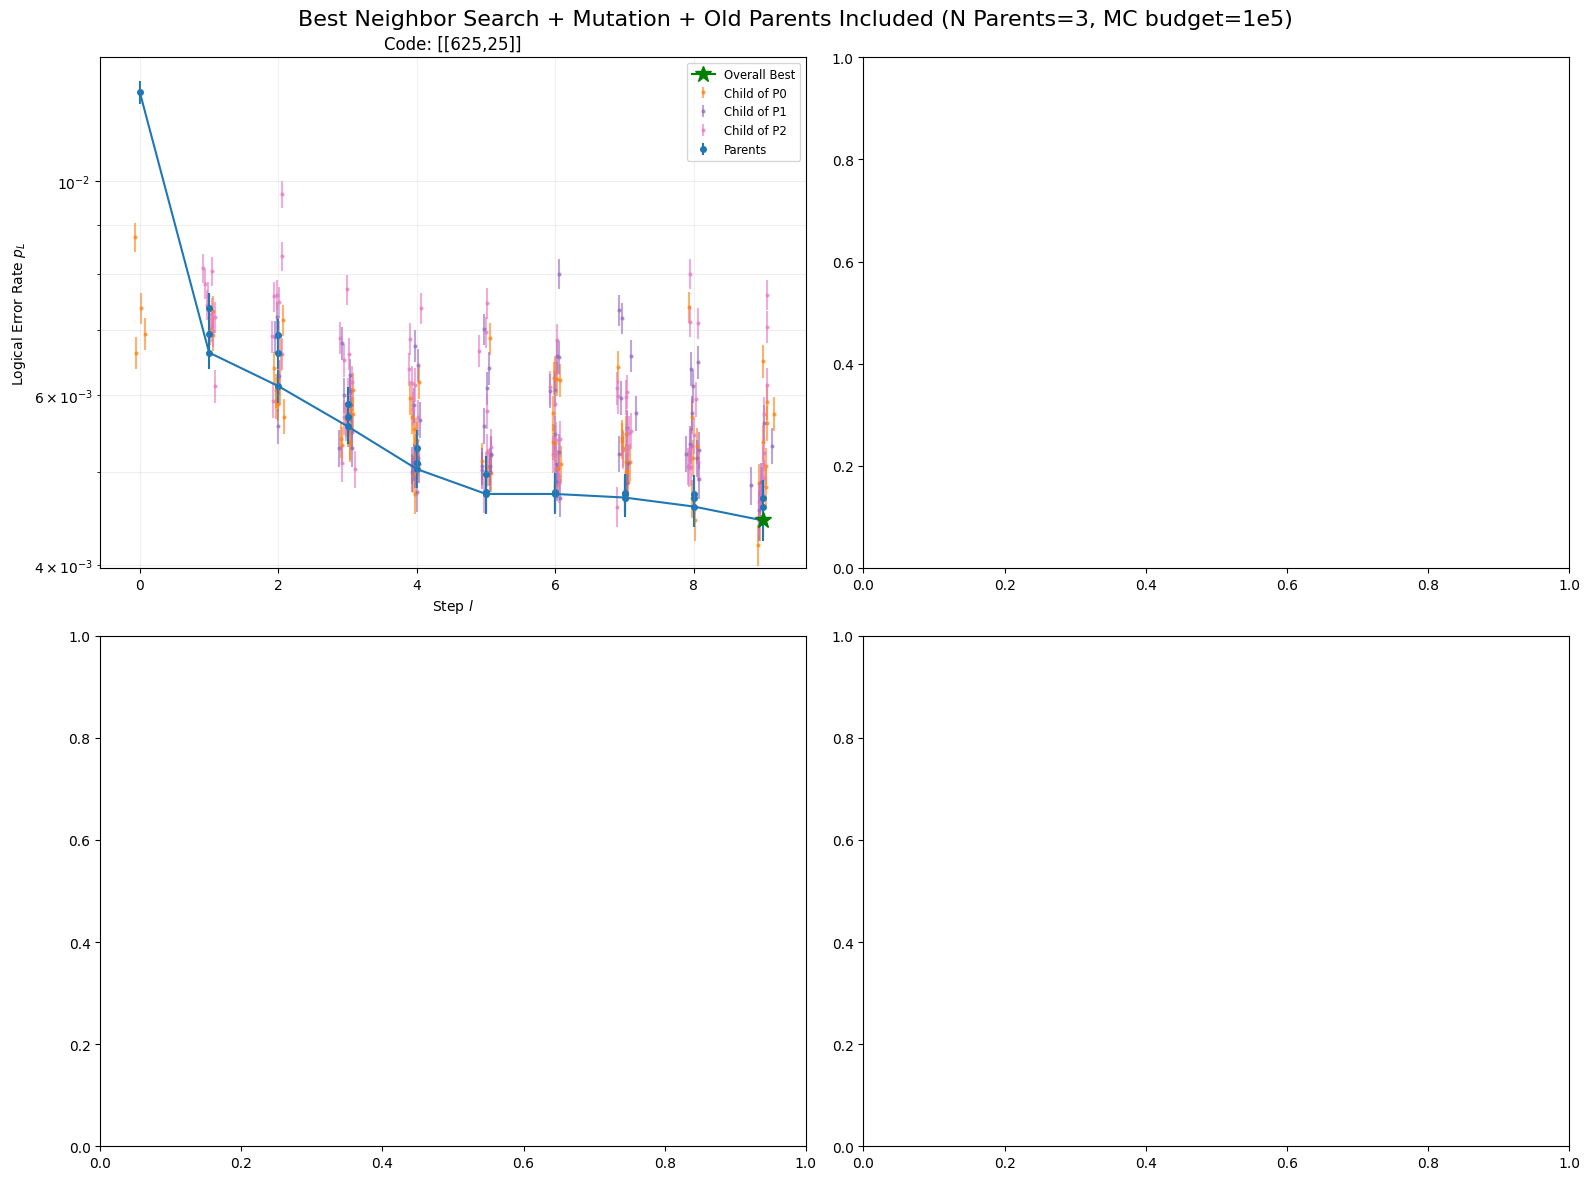

In [46]:
# Settings
filepath = "optimization/results/beam_search_old_parents_included_1e5_run3.hdf5"
code_names = ["[625,25]"]
BEAM_WIDTH = 3    

if __name__ == "__main__":
    plot_beam_search_subplots(filepath, code_names)